In [31]:
%matplotlib inline

import json
import pandas as pd
import glob
import numpy as np
from datetime import datetime
from plotnine import *
import scipy
import sklearn
import statsmodels.api as sm
from tqdm import tqdm_notebook

In [153]:
def parse_timestring(s):
    return datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ')

def drop_constants(df):
    return df.loc[:, (df != df.iloc[0]).any()]

def anonymize(df, column):
    df = pd.DataFrame(df)
    values = df[column].unique()
    indices = {v: i for v, i in zip(values, range(len(values)))}
    df[column] = [indices[v] for v in df[column]]
    return df

In [158]:
data_directory = '/Users/andrew/Desktop/add_experiment/data/raw/exp01'

raw_data = {}
for filename in tqdm_notebook(glob.glob(data_directory + '/*')):
    with open(filename) as f:
        data = json.load(f)
        worker_id = data['hit_params']['workerId']
        if worker_id == 'testWorkerId':
            continue
        raw_data[worker_id] = data
        data['start'] = parse_timestring(data['start'])
        data['end'] = parse_timestring(data['end'])
        data['duration'] = (data['end'] - data['start']).seconds
        for datum in data['datastore']:
            datum['timestamp'] = parse_timestring(datum['timestamp'])
print(len(raw_data))


108


In [34]:
"""
Returns a dataframe with the ITI duration and any late keypresses
"""
def get_iti_data(raw_data, worker_id):
    df = pd.DataFrame(raw_data[worker_id]['datastore'])
    
    #
    iti_next_screen = df[(df.key == 'nextScreenName') & (df.value.str.contains('ITI'))]
    iti_next_screen = iti_next_screen.rename({'value': 'nextITI'}, axis=1)
    iti_next_screen = iti_next_screen[['screenName', 'nextITI']]
    iti_prev_screen = df[(df.key == 'nextScreenName') & (df.screenName.str.contains('ITI'))]
    iti_prev_screen = iti_prev_screen.rename({'screenName': 'prevITI', 'value': 'screenName'}, axis=1)
    iti_prev_screen = iti_prev_screen[['screenName', 'prevITI']]
    
    iti_keypress = df[(df.screenName.str.contains('ITI')) & (df.key.str.contains('input'))]
    iti_keypress = iti_keypress.append([{'timestamp': '2019-11-12T02:57:20.000Z',
                         'type': 'keyPress',
                         'value': 9,
                         'key': 'input2',
                         'screenName': 'calibration_ITI_1'}])
    iti_keypress = iti_keypress.groupby('screenName')['value'].apply(lambda x: ''.join([str(i) for i in x])).reset_index()
    iti_keypress = iti_keypress.rename({'screenName': 'nextITI', 'value': 'lateResponse'}, axis=1)
    
    delays = df[df.screenName.str.contains('ITI')\
                & (df.key == 'duration')\
                & (~df.screenName.str.contains('_end'))]
    delays = delays.rename({'value': 'delay', 'screenName': 'prevITI'}, axis=1)
    delays = delays[['prevITI', 'delay']]
    
    iti = iti_next_screen.merge(iti_prev_screen, on='screenName')
    iti = iti.merge(iti_keypress, on='nextITI', how='left')
    iti = iti.merge(delays, on='prevITI', how='left')
    iti = iti[['screenName', 'delay', 'lateResponse']]
    
    return iti

In [35]:
"""
Returns a dataframe for the RT of first keypress in each screen
"""
def get_rt(raw_data, worker_id):
    df = pd.DataFrame(raw_data[worker_id]['datastore'])
    start_times = df[df.key == 'start'][['screenName', 'timestamp']]
    first_inputs = df[df.key == 'input1'][['screenName', 'timestamp']]
    times = start_times.merge(first_inputs, how='left', on='screenName')
    times['rt'] = [t.total_seconds() for t in (times.timestamp_y - times.timestamp_x)]
    times = times[['screenName', 'rt']]
    return times

In [126]:
def make_dataframe(raw_data, min_accuracy=.8):
    dataframes = []
    for worker_id, data in tqdm_notebook(raw_data.items()):
        df = pd.DataFrame(raw_data[worker_id]['datastore'])
        
        df = df[(df.type.isin({'responseTime', 'response', 'taskDetail'}))]
        df = df[(~df.screenName.str.contains('_ITI_')) & (df.type.isin({'responseTime', 'response', 'taskDetail'}))]
        df = df.pivot(index='screenName', columns='key', values='value')
        df = df.reset_index()
        df = df.merge(get_rt(raw_data, worker_id), on='screenName', how='left')
        df = df.merge(get_iti_data(raw_data, worker_id), on='screenName', how='left')
        
        df.rt = [float(s) if not pd.isna(s) else -1 for s in df.rt]
        df['segment'] = [s.split('_')[0] for s in df.screenName]
        df['warmup'] = df.screenName.str.contains('warmup')
        
        add2set = []
        for record in df.to_records():
            if record.segment == 'add2' and not record.warmup:
                add2set.append(int(record.screenName.split('_')[-2][-1]))
            else:
                add2set.append(np.nan)
        df['set'] = add2set
        df['trial'] = [int(s.split('_')[-1]) for s in df.screenName]
        df['correct'] = df.target == df.response
        df['worker_id'] = worker_id
        df = df[['worker_id', 'segment', 'warmup', 'set', 'trial', 'stimulus', 'target', 'correct', 'response', 'rt', 'lateResponse']]
        
        accuracy = df[(df.segment == 'add2') & (~df.warmup)].correct.mean()
        if accuracy >= min_accuracy:
            dataframes.append(df)
    return pd.concat(dataframes)

In [127]:
def calibration_data(raw_data):
    """
    Returns df which contains median RT for each worker and target
    and agg_df which contains aggregate RT
    """
    
    rows = []
    for worker_id, data in raw_data.items():
        keyboard = [d for d in data['datastore'] if d['key'] == 'keyboard'][0]
        rows.append({'worker_id': worker_id, 'keyboard': keyboard['value']})
    keyboard_df = pd.DataFrame(rows)

    df = make_dataframe(raw_data)
    df = df[(df.segment == 'calibration') & (~df.warmup) & (df.correct)]
    df = df[['worker_id', 'target', 'rt']]
    df = df.groupby(['worker_id', 'target'], as_index=False).mean().merge(keyboard_df)

    sem = df.groupby(['target', 'keyboard']).sem().reset_index()[['target', 'keyboard', 'rt']]
    sem = sem.rename({'rt': 'sem'}, axis=1)
    mean = df.groupby(['target', 'keyboard']).mean().reset_index()[['target', 'keyboard', 'rt']]
    agg_df = sem.merge(mean)
    agg_df['target'] = [str(t).zfill(2) for t in agg_df.target]
    return df, agg_df

In [128]:
df = make_dataframe(raw_data, min_accuracy)
calib_df, calib_agg_df = calibration_data(raw_data)


83

In [148]:
min_accuracy = .8 # remove participants who have lower accuracy than this

df = make_dataframe(raw_data, min_accuracy)
calib_df, calib_agg_df = calibration_data(raw_data)

calib_rt = calib_df.groupby(['worker_id', 'target']).median().reset_index()
calib_rt = {(w, t): rt for w, t, rt in calib_rt.values}
df = df[(df.segment == 'add2') & (~df.warmup)]
df['rt_adj'] = [rt - calib_rt[(w, t)] if (w, t) in calib_rt else np.nan
                for w, t, rt in df[['worker_id', 'target', 'rt']].values]
df['trial_overall'] = df.trial + df.set*147
df.trial_overall = df.trial_overall.astype(int)

df = drop_constants(df)

In [155]:
df['addend1'] = [int(s.split('+')[0]) for s in df.stimulus]
df['addend2'] = [int(s.split('+')[-1]) for s in df.stimulus]
means = df.groupby(['worker_id']).mean().reset_index()
stdevs = df.groupby(['worker_id']).std().reset_index()
mean_rts = {w: rt for w, rt in means[['worker_id', 'rt']].values}
mean_rt_adjs = {w: adj_rt for w, adj_rt in means[['worker_id', 'rt_adj']].values}
stdev_rts = {w: rt for w, rt in stdevs[['worker_id', 'rt']].values}
stdev_rt_adjs = {w: adj_rt for w, adj_rt in stdevs[['worker_id', 'rt_adj']].values}

df['z_rt'] = [(rt - mean_rts[w])/stdev_rts[w] for w, rt in df[['worker_id', 'rt']].values]
df['z_rt_adj'] = [(rt_adj - mean_rt_adjs[w])/stdev_rt_adjs[w] for w, rt_adj in df[['worker_id', 'rt_adj']].values]

df = df[['worker_id', 'set', 'trial', 'trial_overall',
    'stimulus', 'addend1', 'addend2', 'target',
    'correct', 'response', 'lateResponse',
    'rt', 'rt_adj', 'z_rt', 'z_rt_adj']]
df = anonymize(df, 'worker_id')

In [157]:
df.to_csv('../data/clean/add2/add2_rt.tsv', sep='\t', index=False)
df

,worker_id,set,trial,trial_overall,stimulus,addend1,addend2,target,correct,response,lateResponse,rt,rt_adj,z_rt,z_rt_adj
0,0,0.0,0,0,18+17,18,17,35,True,35,NaN,1.654,0.645000,1.381697,1.090222
1,0,0.0,1,1,4+8,4,8,12,True,12,NaN,1.320,0.429000,0.419006,0.487497
2,0,0.0,10,10,14+4,14,4,18,True,18,NaN,1.162,0.262500,-0.036398,0.022897
3,0,0.0,100,100,5+15,5,15,20,True,20,NaN,1.001,0.027333,-0.500449,-0.633311
4,0,0.0,101,101,12+11,12,11,23,False,22,NaN,1.808,0.833667,1.825572,1.616676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,82,2.0,95,389,4+0,4,0,4,True,4,NaN,1.171,0.317500,0.387025,-0.078598
457,82,2.0,96,390,7+17,7,17,24,True,24,NaN,1.473,0.489000,1.454645,0.566565
458,82,2.0,97,391,17+2,17,2,19,True,19,NaN,1.283,0.603333,0.782964,0.996673
459,82,2.0,98,392,11+13,11,13,24,True,24,NaN,1.420,0.436000,1.267281,0.367185


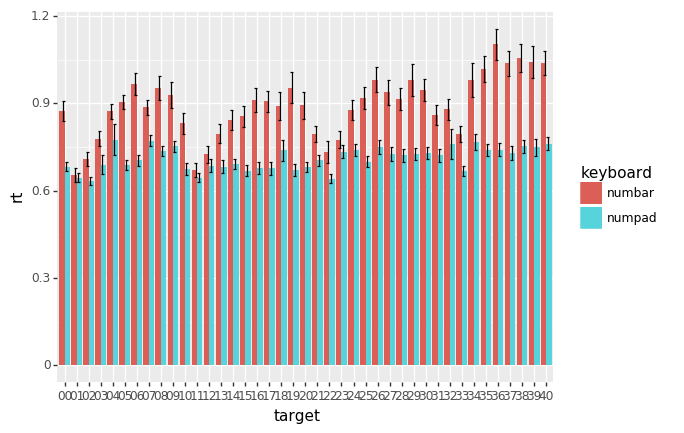

<ggplot: (337742635)>

In [124]:
# calibration_agg
(ggplot(calib_agg_df, aes(x='target', y='rt', fill='keyboard'))
 + geom_bar(stat='identity', position='dodge')
 + geom_errorbar(aes(x="target", ymin="rt-sem",ymax="rt+sem"), position='dodge')
 + aes(ymin=500)
)

In [16]:
df = make_dataframe(raw_data)
df = df[(df.segment == 'add2') & (~df.warmup) & (df.correct)]
df['addend1'] = [int(s.split('+')[0]) for s in df.stimulus]
df['addend2'] = [int(s.split('+')[-1]) for s in df.stimulus]
df['addend1_s'] = [s.split('+')[0].zfill(2) for s in df.stimulus]
df['addend2_s'] = [s.split('+')[-1].zfill(2) for s in df.stimulus]


calib_df, agg_calib_df = calibration_data(raw_data)
calib_df = calib_df.rename({'rt': 'calib_rt'}, axis=1)
# df = df[(df.addend1 <= 10) & (df.addend2 <= 10)]
df = df.merge(calib_df, on=['worker_id', 'target'], how='inner')
df['adjusted_rt'] = df.rt - df.calib_rt

mean_df = df[['addend1', 'addend2', 'rt', 'adjusted_rt']].groupby(['addend1', 'addend2'], as_index=False).mean()
mean_df = mean_df.rename({'rt': 'mean_rt', 'adjusted_rt': 'mean_adj_rt'}, axis=1)
sem_df = df[['addend1', 'addend2', 'rt', 'adjusted_rt']].groupby(['addend1', 'addend2'], as_index=False).mean()
sem_df = mean_df.rename({'rt': 'mean_rt', 'adjusted_rt': 'mean_adj_rt'}, axis=1)

df.to_csv('add2_mturk_results.tsv', sep='\t', index=False)
# agg_df['rt_adjustment'] = agg_df.rt - agg_df.adjusted_rt

In [17]:
rts = df[['worker_id', 'addend1', 'addend2', 'rt', 'adjusted_rt']]
rts.to_csv('add2_rts.tsv', sep='\t', index=False)

In [18]:
rows = []
for worker_id in tqdm_notebook(rts.worker_id.unique()):
    mean_df = rts[rts.worker_id != worker_id][['addend1', 'addend2', 'rt', 'adjusted_rt']]
    mean_df = mean_df.groupby(['addend1', 'addend2'], as_index=False).mean()
    compare_df = mean_df.merge(rts[rts.worker_id == worker_id], on=['addend1', 'addend2'], how='inner')
    compare_df = compare_df.rename({'rt_x': 'mean_rt', 'adjusted_rt_x': 'mean_adj_rt',
                                    'rt_y': 'model_rt', 'adjusted_rt_y': 'model_adj_rt'}, axis=1)
    compare_df = compare_df[['mean_rt', 'mean_adj_rt', 'model_rt', 'model_adj_rt']]
    rt_r2 = sm.OLS(compare_df.mean_rt, sm.add_constant(compare_df.model_rt)).fit().rsquared
    adj_rt_r2 = sm.OLS(compare_df.mean_adj_rt, sm.add_constant(compare_df.model_adj_rt)).fit().rsquared
    
    rows.append({'worker_id': worker_id, 'rt_r2': rt_r2, 'adj_rt_r2': adj_rt_r2})
    
r2_df = pd.DataFrame(rows)

/Users/andrew/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [19]:
r2_df.describe()

,rt_r2,adj_rt_r2
count,82.000000,82.000000
mean,0.411038,0.391279
std,0.161381,0.169253
min,0.021253,0.000138
25%,0.333991,0.294776
50%,0.434821,0.419801
75%,0.520871,0.511242
max,0.699184,0.679203


In [582]:
r2_df.sem()

rt_r2        0.037645
adj_rt_r2    0.031876
dtype: float64

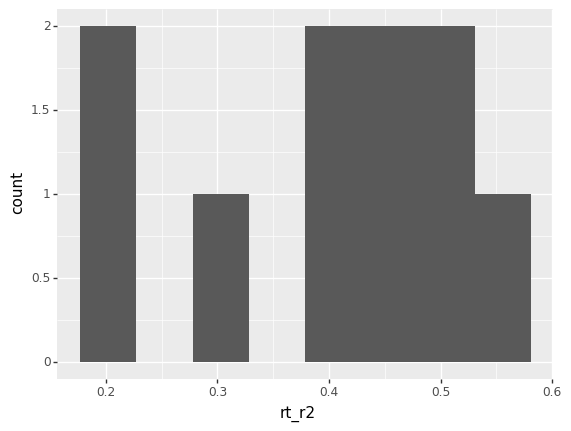

<ggplot: (-9223372036545902939)>

In [43]:
plot = (ggplot(r2_df)
     + aes(x='rt_r2')
     + geom_histogram(bins=8)
#      + labs(title='Mental Addition Response Time (n={})'.format(len(raw_data)))
    )
plot

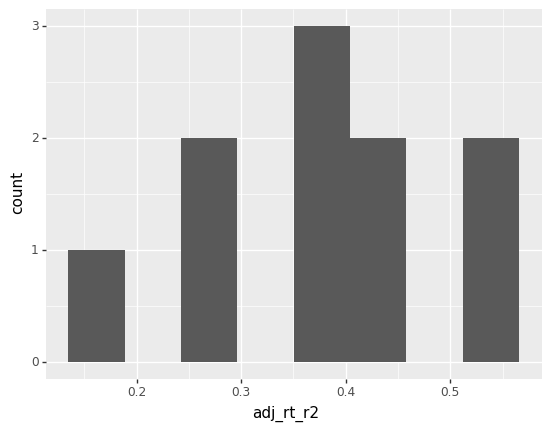

<ggplot: (-9223372036546296390)>

In [45]:
plot = (ggplot(r2_df)
     + aes(x='adj_rt_r2')
     + geom_histogram(bins=8)
#      + labs(title='Mental Addition Response Time (n={})'.format(len(raw_data)))
    )
plot

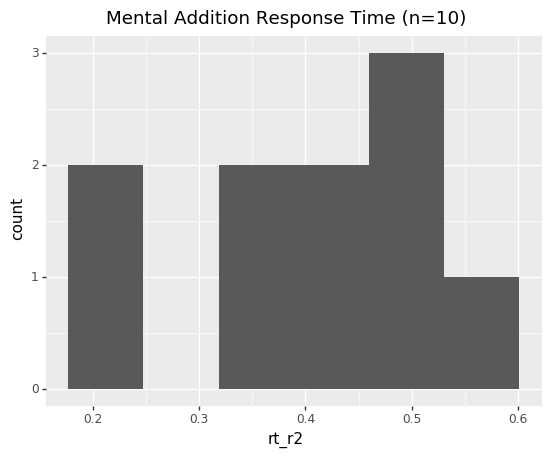

<ggplot: (-9223372036545902911)>

In [46]:
plot = (ggplot(r2_df)
     + aes(x='rt_r2')
     + geom_histogram(bins=6)
     + labs(title='Mental Addition Response Time (n={})'.format(len(raw_data)))
    )
plot

In [ ]:
plot = (ggplot(df)
     + aes(x='addend1_s', y='addend2_s', fill='rt')
     + geom_tile()       
     + scale_x_discrete(limits=sorted(df.addend1_s.unique()))
     + scale_y_discrete(limits=sorted(df.addend2_s.unique()))
     + coord_equal()
     + scale_fill_gradientn(colors = ['blue', 'yellowgreen', 'yellow', 'orange', 'red'])
     + labs(title='Mental Addition Response Time (n={})'.format(len(raw_data)))
     + theme(
         figure_size=(12, 12),
         panel_background=element_rect(fill='black'),
         line=element_line(color='black'),
         panel_border=element_blank()
        )
    )
plot

In [414]:
geom_histogram(mapping=None, data=None, stat='bin', position='stack',
               na_rm=False, inherit_aes=True, show_legend=None, **kwargs)

,worker_id,trial,delay,rt,calib_rt,keyboard,adjusted_rt
71,AC5FF0SJI0RXM,82,781,789,803.000000,numbar,-14.000000
148,A1WELSASLGM0P4,76,771,1374,969.333333,numbar,404.666667
308,A37DKV7XQI7N5J,66,527,814,772.000000,numpad,42.000000
379,A315GZMPR49WIY,58,632,1318,930.666667,numpad,387.333333
566,A1KFTQRBMXSC13,37,508,1031,812.000000,numpad,219.000000
678,A3LE1BIVORW3VR,12,779,808,828.333333,numpad,-20.333333
844,A2WY6HLF2YLSOF,44,820,1587,779.000000,numpad,808.000000
937,A2871R3LEPWMMK,75,761,955,973.500000,numbar,-18.500000
1050,AMONQ9MU8EJ2,33,933,1452,1473.000000,numbar,-21.000000
1130,A83OOIGU4606R,72,861,1194,1002.666667,numbar,191.333333


In [396]:
scipy.stats.pearsonr(df.mean_rt, df.rt)

(0.2749924946648373, 0.0023682163010195884)

In [398]:
sklearn.metrics.r2_score(df.mean_rt, df.rt)

-0.19955178076696978

In [35]:
df = df[['addend1_s', 'addend2_s', 'rt', 'adjusted_rt']].groupby(['addend1_s', 'addend2_s'], as_index=False).mean()
df['rt_adjustment'] = df.rt - df.adjusted_rt

In [38]:
df = make_dataframe(raw_data)
df = df[(df.segment == 'add2') & (~df.warmup) & (df.correct)]
df['addend1'] = [int(s.split('+')[0]) for s in df.stimulus]
df['addend2'] = [int(s.split('+')[-1]) for s in df.stimulus]
df['addend1_s'] = [s.split('+')[0].zfill(2) for s in df.stimulus]
df['addend2_s'] = [s.split('+')[-1].zfill(2) for s in df.stimulus]


calib_df, agg_calib_df = calibration_data(raw_data)
calib_df = calib_df.rename({'rt': 'calib_rt'}, axis=1)
# df = df[(df.addend1 <= 9) & (df.addend2 <= 9)]
df = df.merge(calib_df, on=['worker_id', 'target'], how='inner')
df['adjusted_rt'] = df.rt - df.calib_rt

agg_df = df.groupby(['addend1_s', 'addend2_s'], as_index=False).mean()
agg_df = agg_df[['addend1_s', 'addend2_s', 'rt', 'adjusted_rt']]

# agg_df['rt_adjustment'] = agg_df.rt - agg_df.adjusted_rt


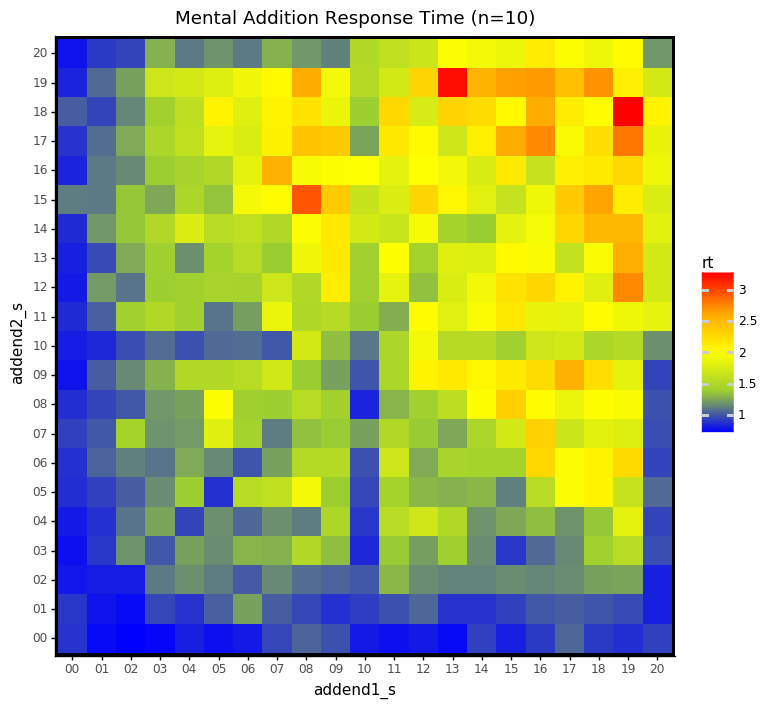

<ggplot: (-9223372036547365109)>

In [39]:
plot = (ggplot(agg_df)
     + aes(x='addend1_s', y='addend2_s', fill='rt')
     + geom_tile()       
     + scale_x_discrete(limits=sorted(agg_df.addend1_s.unique()))
     + scale_y_discrete(limits=sorted(agg_df.addend2_s.unique()))
     + coord_equal()
     + scale_fill_gradientn(colors = ['blue', 'yellowgreen', 'yellow', 'orange', 'red'])
     + labs(title='Mental Addition Response Time (n={})'.format(len(raw_data)))
     + theme(
         figure_size=(8, 8),
         panel_background=element_rect(fill='black'),
         line=element_line(color='black'),
         panel_border=element_blank()
        )
    )
plot

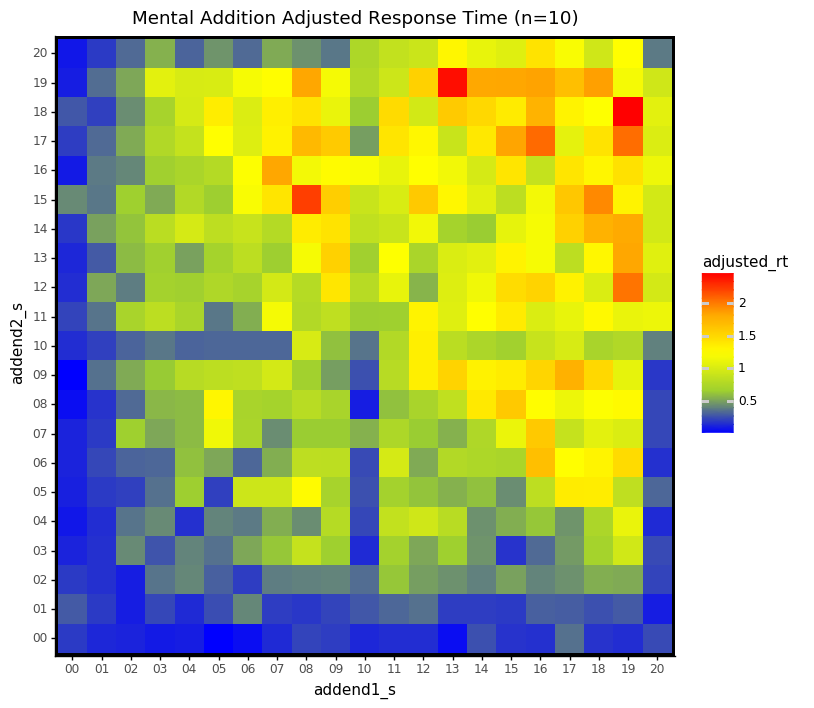

<ggplot: (307430895)>

In [40]:
plot = (ggplot(agg_df)
     + aes(x='addend1_s', y='addend2_s', fill='adjusted_rt')
     + geom_tile()       
     + scale_x_discrete(limits=sorted(agg_df.addend1_s.unique()))
     + scale_y_discrete(limits=sorted(agg_df.addend2_s.unique()))
     + coord_equal()
     + scale_fill_gradientn(colors = ['blue', 'yellowgreen', 'yellow', 'orange', 'red'])
     + labs(title='Mental Addition Adjusted Response Time (n={})'.format(len(raw_data)))
     + theme(
         figure_size=(8, 8),
         panel_background=element_rect(fill='black'),
         line=element_line(color='black'),
         panel_border=element_blank()
        )
    )
plot

In [492]:
df = make_dataframe(raw_data)
df = df[(df.segment == 'add2') & (~df.warmup) & (df.correct)]
df['addend1'] = [int(s.split('+')[0]) for s in df.stimulus]
df['addend2'] = [int(s.split('+')[-1]) for s in df.stimulus]
df['addend1_s'] = [s.split('+')[0].zfill(2) for s in df.stimulus]
df['addend2_s'] = [s.split('+')[-1].zfill(2) for s in df.stimulus]

agg_df = df.groupby(['addend1_s', 'addend2_s'], as_index=False).mean()
agg_df = agg_df[['addend1_s', 'addend2_s', 'rt']]

# agg_df['rt_adjustment'] = agg_df.rt - agg_df.adjusted_rt


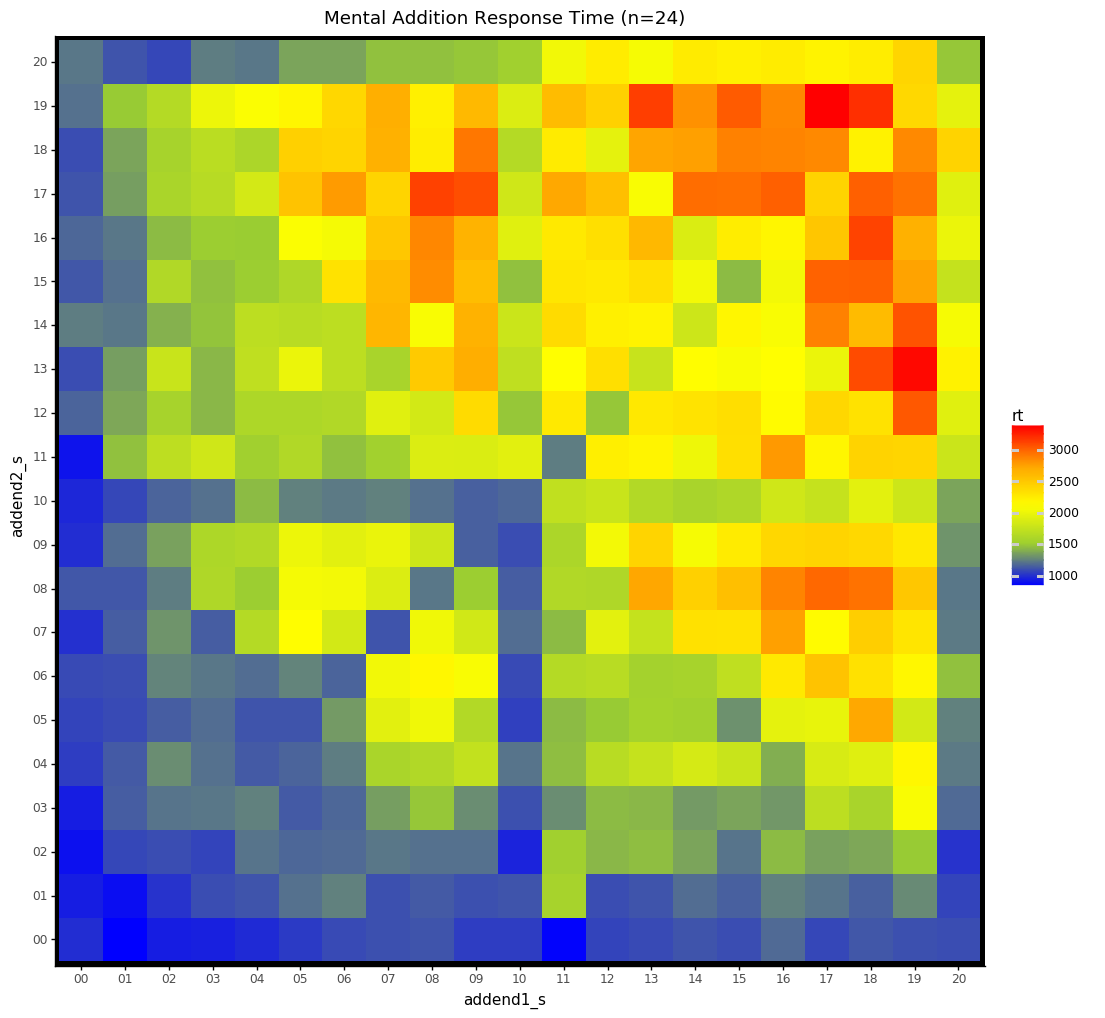

<ggplot: (-9223372036541113926)>

In [494]:
plot = (ggplot(agg_df)
     + aes(x='addend1_s', y='addend2_s', fill='rt')
     + geom_tile()       
     + scale_x_discrete(limits=sorted(df.addend1_s.unique()))
     + scale_y_discrete(limits=sorted(df.addend2_s.unique()))
     + coord_equal()
     + scale_fill_gradientn(colors = ['blue', 'yellowgreen', 'yellow', 'orange', 'red'])
     + labs(title='Mental Addition Response Time (n={})'.format(len(raw_data)))
     + theme(
         figure_size=(12, 12),
         panel_background=element_rect(fill='black'),
         line=element_line(color='black'),
         panel_border=element_blank()
        )
    )
plot

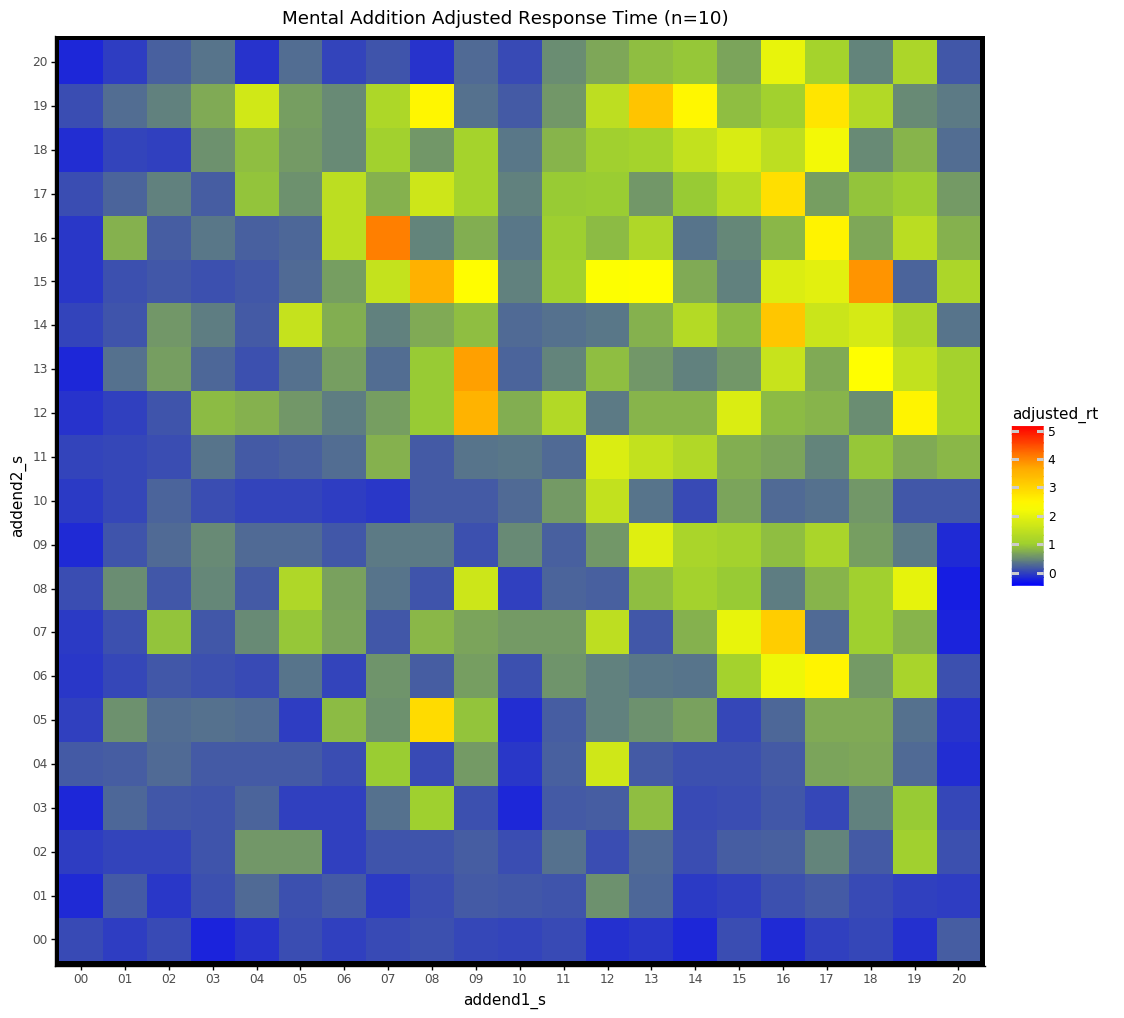

<ggplot: (308672120)>

In [41]:
plot = (ggplot(df)
     + aes(x='addend1_s', y='addend2_s', fill='adjusted_rt')
     + geom_tile()       
     + scale_x_discrete(limits=sorted(df.addend1_s.unique()))
     + scale_y_discrete(limits=sorted(df.addend2_s.unique()))
     + coord_equal()
     + scale_fill_gradientn(colors = ['blue', 'yellowgreen', 'yellow', 'orange', 'red'])
     + labs(title='Mental Addition Adjusted Response Time (n={})'.format(len(raw_data)))
     + theme(
         figure_size=(12, 12),
         panel_background=element_rect(fill='black'),
         line=element_line(color='black'),
         panel_border=element_blank()
        )
    )
plot

In [42]:
plot = (ggplot(df)
     + aes(x='addend1_s', y='addend2_s', fill='rt_adjustment')
     + geom_tile()       
     + scale_x_discrete(limits=sorted(df.addend1_s.unique()))
     + scale_y_discrete(limits=sorted(df.addend2_s.unique()))
     + coord_equal()
     + scale_fill_gradientn(colors = ['blue', 'yellowgreen', 'yellow', 'orange', 'red'])
     + labs(title='Mental Addition RT Adjustment (n={})'.format(len(raw_data)))
     + theme(
         figure_size=(12, 12),
         panel_background=element_rect(fill='black'),
         line=element_line(color='black'),
         panel_border=element_blank()
        )
    )
plot

PlotnineError: "Could not evaluate the 'fill' mapping: 'rt_adjustment' (original error: name 'rt_adjustment' is not defined)"